In [1]:
import fairlib as fl
from fairlib.inprocessing import Fauci
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from tests.data_generator import biased_dataset_people_height

from fairlib import keras
keras.utils.set_random_seed(423)


2024-12-16 17:19:13.575211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734365953.595081 4047885 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734365953.601130 4047885 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 17:19:13.621173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:fairlib:Using Keras backend: TENSORFLOW
INFO:fairlib:fairlib loaded


In [2]:
dataset = biased_dataset_people_height(binary=True)
X = dataset.drop(columns=['class'], axis=1).values
y = dataset['class'].values

In [3]:
dataset

,height,class,male
0,179.461261,1,1
1,160.989611,0,1
2,163.323137,0,1
3,171.553938,1,1
4,116.535270,0,0
...,...,...,...
9995,141.536912,0,1
9996,191.528178,1,1
9997,142.457990,0,0
9998,142.033719,0,1


In [4]:
dataset.statistical_parity_difference()

(class=0, male=0) -> -0.319767577003299
(class=0, male=1) -> 0.319767577003299
(class=1, male=0) -> 0.319767577003299
(class=1, male=1) -> -0.319767577003299

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
dataset.targets = "class"
dataset.sensitive = 'male' # fauci currently supports only one sensitive attribute

In [7]:
test_data = fl.DataFrame(X_test, columns=['height', 'male'])
test_data['male'] = test_data['male'].astype(int)
test_data['class'] = y_test
test_data.targets = "class"
test_data.sensitive = 'male'
test_data

,height,male,class
0,187.330040,1,1
1,177.595211,1,1
2,150.488624,1,0
3,161.407366,0,1
4,162.339374,0,1
...,...,...,...
1995,168.896291,0,1
1996,173.782952,0,1
1997,143.182428,1,0
1998,122.936792,0,0


In [8]:
def create_model():
    model = Sequential()
    model.add(Dense(4, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [9]:
learning_params = dict(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
W = 0.8

In [10]:
unwrapped = create_model()
unwrapped.compile(**learning_params)

2024-12-16 17:19:15.950043: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
unprocessed = Fauci(create_model(), regularizer=None, regularization_weight=0.0, **learning_params)

In [12]:
inprocessing_spd = Fauci(create_model(), regularizer='sp', regularization_weight=W, **learning_params)

In [13]:
inprocessing_di = Fauci(create_model(), regularizer='di', regularization_weight=W, **learning_params)

In [14]:
EPOCHS = 200
BATCH_SIZE = 500
VALIDATION_SPLIT=0.3

In [ ]:
unwrapped.fit(X_train.astype(float), y_train.astype(float), epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

In [ ]:
unprocessed.fit(dataset, converting_to_type=float, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

In [17]:
inprocessing_spd.fit(dataset, converting_to_type=float, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 256s 31ms/step - accuracy: 0.4438 - loss: 0.5108 - val_accuracy: 0.5590 - val_loss: 0.2163
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5620 - loss: 0.1885 - val_accuracy: 0.4410 - val_loss: 0.1585
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4633 - loss: 0.1494 - val_accuracy: 0.5590 - val_loss: 0.1356
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6135 - loss: 0.1321 - val_accuracy: 0.6577 - val_loss: 0.1311
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7016 - loss: 0.1311 - val_accuracy: 0.7320 - val_loss: 0.1305
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7144 - loss: 0.1306 - val_accuracy: 0.6827 - val_loss: 0.1293
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6834 - loss: 0.1294 - val_accuracy: 0.7827 - val_loss: 0.1290
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7192 - loss: 0.1290 - val_accuracy: 

KeyboardInterrupt: 

In [ ]:
inprocessing_di.fit(dataset, converting_to_type=float, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/200


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4340 - loss: 12.7167 - val_accuracy: 0.4410 - val_loss: 12.0144
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4340 - loss: 11.9152 - val_accuracy: 0.4410 - val_loss: 11.2306
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4340 - loss: 11.1285 - val_accuracy: 0.4410 - val_loss: 10.4624
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4340 - loss: 10.3576 - val_accuracy: 0.4410 - val_loss: 9.7097
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4340 - loss: 9.6021 - val_accuracy: 0.4410 - val_loss: 8.9714
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4340 - loss: 8.8608 - val_accuracy: 0.4410 - val_loss: 8.2463
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4340 - loss: 8.1325 - val_accuracy: 0.4410 - val_loss: 7.5331
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4340 - loss: 7.4159 - val_accuracy: 0.4410 

In [ ]:
y_pred_unwrapped = unwrapped.predict(X_test)
y_pred_unprocessed = unprocessed.predict(test_data)
y_pred_spd = inprocessing_spd.predict(test_data)
y_pred_di = inprocessing_di.predict(test_data)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [ ]:
y_pred_unwrapped = (y_pred_unwrapped > 0.5).astype(int)
y_pred_unprocessed = (y_pred_unprocessed > 0.5).astype(int)
y_pred_spd = (y_pred_spd > 0.5).astype(int)
y_pred_di = (y_pred_di > 0.5).astype(int)

In [ ]:
experiments = ['unwrapped', 'unprocessed', 'spd', 'di']
accuracies = []
spds = []
dis = []

for experiment in experiments:
    print("=" * 10, experiment, "=" * 10)
    data = test_data.copy()
    expected = data['class']
    data['class'] = locals()[f'y_pred_{experiment}']
    case = {'class': 1, 'male': 0}
    accuracies.append(accuracy_score(expected, data['class']))
    print("accuracy:", accuracies[-1])
    spds.append(abs(data.statistical_parity_difference()[case]))
    print("statistical_parity_difference:", spds[-1])
    dis.append(abs(data.disparate_impact()[case]))
    print("disparate_impact:", dis[-1])

========== unwrapped ==========
accuracy: 0.8235
statistical_parity_difference: 0.7035543424026298
disparate_impact: 0.25011105619130447
========== unprocessed ==========
accuracy: 0.7915
statistical_parity_difference: 0.7362038096915265
disparate_impact: 0.19436771715251103
========== spd ==========
accuracy: 0.828
statistical_parity_difference: 0.652760412080655
disparate_impact: 0.23968247456514605
========== di ==========
accuracy: 0.818
statistical_parity_difference: 0.7377124240556485
disparate_impact: 0.25133145083461417


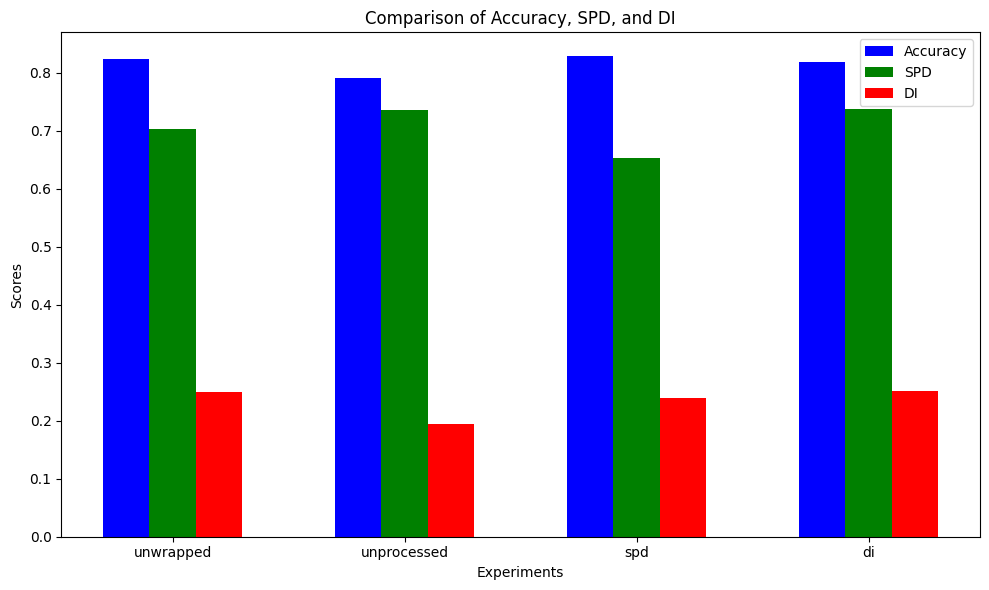

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

# Define the bar width and positions
bar_width = 0.2
index = np.arange(len(experiments))

# Plot each metric as a triplet of bars
ax.bar(index, accuracies, bar_width, label='Accuracy', color='blue')
ax.bar(index + bar_width, spds, bar_width, label='SPD', color='green')
ax.bar(index + 2 * bar_width, dis, bar_width, label='DI', color='red')

# Set the labels and title
ax.set_xlabel('Experiments')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Accuracy, SPD, and DI')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(experiments)
ax.legend()

plt.tight_layout()
plt.show()
